In [1]:
import pandas as pd 
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date

In [2]:
off_train = pd.read_csv('ccf_offline_stage1_train.csv')
off_test = pd.read_csv('ccf_offline_stage1_test_revised.csv')

In [55]:
print(off_train.shape)
print(off_test.shape)

(1754884, 19)
(113640, 17)


In [4]:
off_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754884 entries, 0 to 1754883
Data columns (total 7 columns):
User_id          int64
Merchant_id      int64
Coupon_id        float64
Discount_rate    object
Distance         float64
Date_received    float64
Date             float64
dtypes: float64(4), int64(2), object(1)
memory usage: 93.7+ MB


In [15]:
#定义缺失值检测函数
def MissingValuesFunc(df):
    mis_val = df.isnull().sum()
    mis_val_percent = (df.isnull().sum()/len(df)) * 100
    mis_val_table = pd.concat([mis_val,mis_val_percent],axis=1)
    mis_val_table = mis_val_table.rename(columns = {0:'缺失值', 1 : '缺失率(%)'})
    mis_val_table = mis_val_table[mis_val_table.iloc[:,1] != 0].sort_values('缺失率(%)',ascending=False)
    return mis_val_table

In [16]:
#线下训练集优惠券消费的缺失值
missing_off_train = MissingValuesFunc(off_train)
missing_off_train

,缺失值,缺失率(%)
Date,977900,92.843132
Distance,106003,10.064066
discount_man,33272,3.158888
discount_jian,33272,3.158888


In [47]:
#线下测试集优惠券消费的缺失值
missing_off_test = MissingValuesFunc(off_test)
missing_off_test

,缺失值,缺失率(%)
Distance,12064,10.615980
discount_man,2566,2.258008
discount_jian,2566,2.258008


In [3]:
#将Date_received和Date转换为时间格式
off_train['Date_received'] = pd.to_datetime(off_train['Date_received'],format='%Y%m%d')
off_train['Date'] = pd.to_datetime(off_train['Date'],format='%Y%m%d')

In [4]:
#定义目标变量
def TargetFunc(df):
    if pd.isnull(df['Date_received']):
        return -1 
    elif pd.notnull(df['Date']):
        if ((df['Date'] - df['Date_received']).days) <= 15:
            return 1 
    return 0 

In [5]:
off_train['Target'] = off_train.apply(TargetFunc,axis=1)

In [7]:
off_train['Target'].value_counts()

0    988887
1     64395
Name: Target, dtype: int64

In [138]:
off_train.shape

(1053282, 12)

In [6]:
#处理Discount_rate列中的折扣类型，生成新的特征
def DiscountType(x):
    if pd.isnull(x):
        return np.nan
    elif ':' in x:
        return 1
    elif '.' in x:
        return 0

def ConvertRate(x):
    if pd.isnull(x):
        return np.nan
    elif ':' in x:
        x_split = x.split(':')
        return 1.0 - float(x_split[1])/float(x_split[0])
    elif '.' in x:
        return float(x)

def DiscountMan(x):
    if pd.isnull(x):
        return np.nan
    elif ':'in x:
        x_split = x.split(':')
        return int(x_split[0])
    else:
        return np.nan

def DiscountJian(x):
    if pd.isnull(x):
        return np.nan
    elif ':'in x:
        x_split = x.split(':')
        return int(x_split[1])
    else:
        return np.nan

In [7]:
def DiscountFunc(df):
    df['discount_rate'] = df['Discount_rate'].apply(ConvertRate)
    df['discount_man'] = df['Discount_rate'].apply(DiscountMan)
    df['discount_jian'] = df['Discount_rate'].apply(DiscountJian)
    df['discount_type'] = df['Discount_rate'].apply(DiscountType)
    return df

In [8]:
off_train = DiscountFunc(off_train)
off_test = DiscountFunc(off_test)

In [9]:
off_train.drop('Discount_rate',axis=1,inplace=True)
off_test.drop('Discount_rate',axis=1,inplace=True)

In [12]:
print(off_train.shape)
print(off_test.shape)

(1053282, 11)
(113640, 9)


In [31]:
def PlotStats(feature):
    temp = off_train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'数量': temp.values})
    
    df2 = off_train[(off_train['Target'] == 0) | (off_train['Target'] == 1) ].groupby(feature,as_index=False)['Target'].mean()
    df2.sort_values(by='Target', ascending=False, inplace=True)
    
    plt.figure(figsize=(16,6))
    plt.rcParams['font.sans-serif']=['SimHei']
    
    plt.subplot(1,2,1)
    sns.barplot(x=feature, y="数量",data=df1)
    
    plt.subplot(1,2,2)
    sns.barplot(x=feature, y='Target', order=df2[feature], data=df2)
    plt.ylabel('核销率占比 [%]', fontsize=10)
    
    

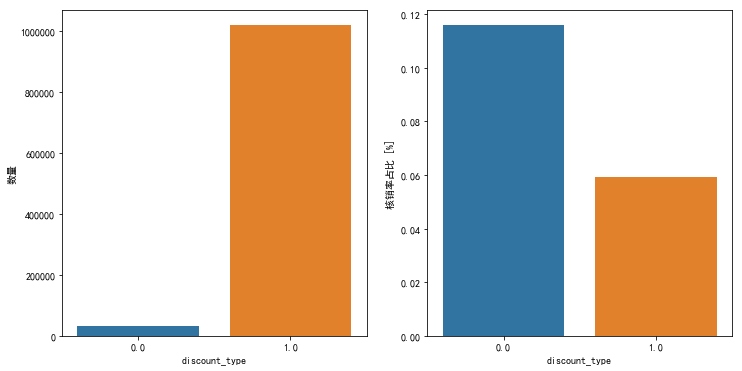

In [59]:
#虽然折扣类型中直接折扣比满减的数量要少，但是直接折扣的核销率更高
PlotStats('discount_type')

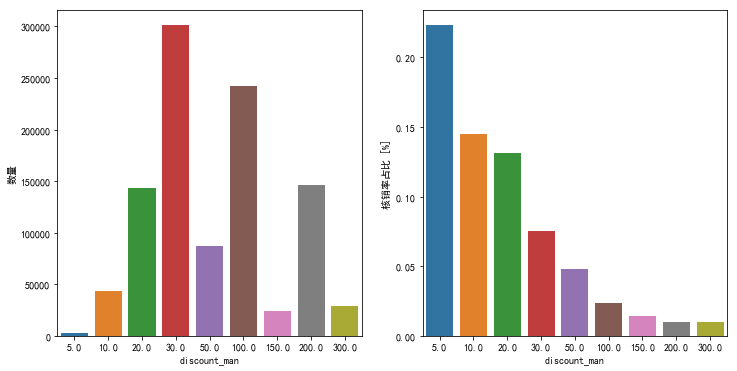

In [60]:
#优惠券折扣门槛的价格越高，核销率越低
PlotStats('discount_man')

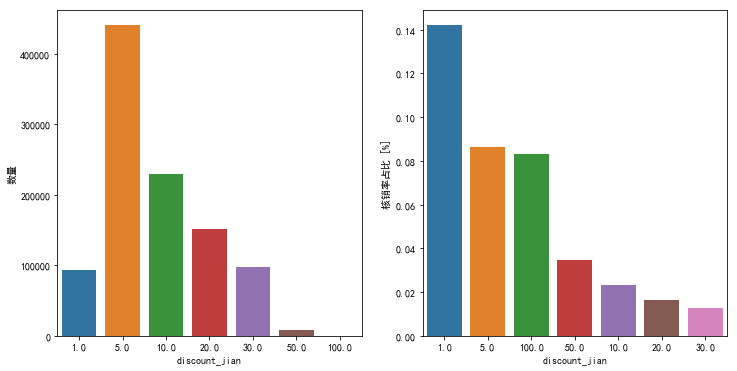

In [61]:
#减100的优惠券和减1、5的优惠券核销率更高，反而减的不多不少的核销率较低
PlotStats('discount_jian')

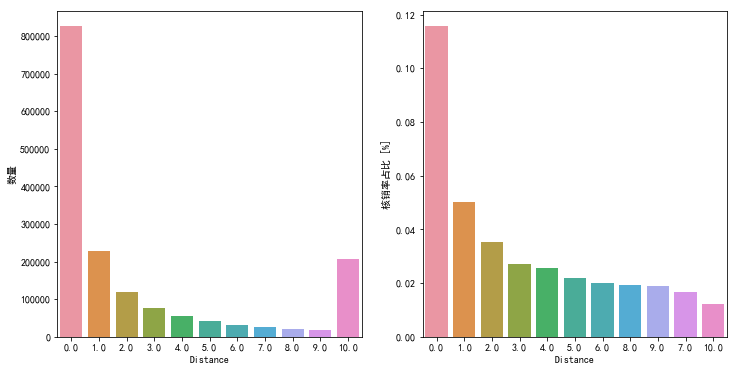

In [62]:
#user经常活动的地点离门店距离越近，核销率越高
PlotStats('Distance')

In [42]:
def PlotKde(feature):
    plt.figure(figsize = (12, 6))
    sns.kdeplot(off_train.loc[off_train['Target'] == 0, feature], label = 'Target == 0')
    sns.kdeplot(off_train.loc[off_train['Target'] == 1, feature], label = 'Target == 1')
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus']=False
    plt.title('%s 优惠券消费情况分布' % feature)
    plt.xlabel('%s' % feature)
    plt.ylabel('Density')

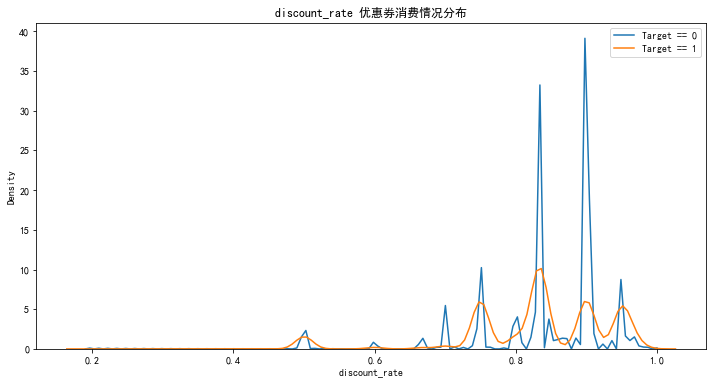

In [43]:
#优惠券直接折扣率集中在0.7至0.95之间，优惠券的使用在0.8折扣附近更高，不使用的优惠券在0.8至0.9之间更高
PlotKde('discount_rate')

In [11]:
#线下领取优惠券的日期是一周中的第几天
off_train['day_of_week'] = off_train['Date_received'].dt.dayofweek

In [12]:
off_test['day_of_week'] = pd.to_datetime(off_test['Date_received'], format='%Y%m%d').dt.dayofweek

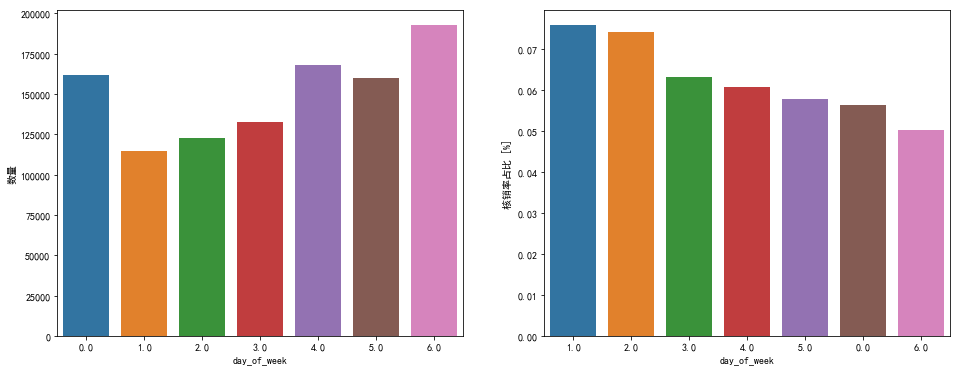

In [32]:
#线下周末领取优惠券的核销率较低，星期六领的最多却用的最少
PlotStats('day_of_week')

In [13]:
weekdaycols = ['weekday_' + str(i) for i in range(0,7)]

week_train = pd.get_dummies(off_train['day_of_week'])
week_train.columns = weekdaycols
off_train[weekdaycols] = week_train

week_test = pd.get_dummies(off_test['day_of_week'])
week_test.columns = weekdaycols
off_test[weekdaycols] = week_test

In [14]:
feature = off_train[(off_train['Date'] < '20160516') | ((off_train['Date'] == 'null') & (off_train['Date_received'] < '20160516'))].copy()
feature['rec_con_interval'] = (feature['Date'] - feature['Date_received']).dt.days
data = off_train[(off_train['Date_received'] >= '20160516') & (off_train['Date_received'] <= '20160615')].copy()
print(data['Target'].value_counts())

0    229715
1     22871
Name: Target, dtype: int64


In [15]:
def UserFeature(df):
    u_unique_id = df[['User_id']].copy().drop_duplicates()
    #用户线下领取优惠券总次数
    u_rec_count = df.groupby('User_id',as_index=False)['Date_received'].count().rename(columns={'Date_received':'u_rec_count'})
    #用户线下优惠券核销总次数
    u_con_count = df.groupby('User_id',as_index=False)['Date'].count().rename(columns={'Date':'u_con_count'})
    #用户线下优惠券核销商家数
    u_con_m_count = df.groupby('User_id')['Merchant_id'].nunique().reset_index().rename(columns={'Merchant_id':'u_con_m_count'})
    #用户线下满减优惠券平均核销门槛
    u_man_con_thre_mean = df.groupby('User_id',as_index=False)['discount_man'].mean().rename(columns={'discount_man':'u_man_con_thre_mean'})
    #用户线下满减优惠券最大核销门槛
    u_man_con_thre_max = df.groupby('User_id',as_index=False)['discount_man'].max().rename(columns={'discount_man':'u_man_con_thre_max'})
    #用户线下满减优惠券最小核销门槛
    u_man_con_thre_min = df.groupby('User_id',as_index=False)['discount_man'].min().rename(columns={'discount_man':'u_man_con_thre_min'})
    #用户线下优惠券核销平均折扣率
    u_con_dis_rate_mean = df.groupby('User_id',as_index=False)['discount_rate'].mean().rename(columns={'discount_rate':'u_con_dis_rate_mean'})
    #用户线下优惠券核销最大折扣率
    u_con_dis_rate_max = df.groupby('User_id',as_index=False)['discount_rate'].max().rename(columns={'discount_rate':'u_con_dis_rate_max'})
    #用户线下优惠券核销最小折扣率
    u_con_dis_rate_min= df.groupby('User_id',as_index=False)['discount_rate'].min().rename(columns={'discount_rate':'u_con_dis_rate_min'}) 
    #用户线下优惠券核销的平均距离
    u_con_dist_mean = df.groupby('User_id',as_index=False)['Distance'].mean().rename(columns={'Distance':'u_con_dist_mean'})
    #用户线下优惠券核销的最大距离
    u_con_dist_max = df.groupby('User_id',as_index=False)['Distance'].max().rename(columns={'Distance':'u_con_dist_max'})
    #用户线下优惠券核销的最小距离
    u_con_dist_min = df.groupby('User_id',as_index=False)['Distance'].min().rename(columns={'Distance':'u_con_dist_min'})
    #用户线下满减优惠券领取次数
    u_manjian_rec_count = df[df['discount_man'].notnull()].groupby('User_id',as_index=False)['Date_received'].count().rename(columns={'Date_received':'u_manjian_rec_count'})
    #用户线下满减优惠券核销次数
    u_manjian_con_count = df[df['discount_man'].notnull()].groupby('User_id',as_index=False)['Date'].count().rename(columns={'Date':'u_manjian_con_count'})
    #用户线下优惠券核销平均时间间隔
    u_interval_mean = df.groupby('User_id',as_index=False)['rec_con_interval'].mean().rename(columns={'rec_con_interval':'u_interval_mean'})
    #用户线下优惠券核销最大时间间隔
    u_interval_max = df.groupby('User_id',as_index=False)['rec_con_interval'].max().rename(columns={'rec_con_interval':'u_interval_max'})
    #用户线下优惠券核销最小时间间隔
    u_interval_min = df.groupby('User_id',as_index=False)['rec_con_interval'].min().rename(columns={'rec_con_interval':'u_interval_min'})
    
    
    
    user_feature = pd.merge(u_unique_id,u_rec_count, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u_con_count, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u_con_m_count, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u_man_con_thre_mean, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u_man_con_thre_max, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u_man_con_thre_min, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u_con_dis_rate_mean, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u_con_dis_rate_max, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u_con_dis_rate_min, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u_con_dist_mean, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u_con_dist_max, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u_con_dist_min, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u_manjian_rec_count, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u_manjian_con_count, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u_interval_mean, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u_interval_max, on = 'User_id', how = 'left')
    user_feature = pd.merge(user_feature, u_interval_min, on = 'User_id', how = 'left')
    
    #用户线下优惠券核销率
    user_feature['u_rec_con_rate'] = user_feature['u_con_count'] / user_feature['u_rec_count']
    #用户线下满减优惠券核销率
    user_feature['u_manjian_rate'] = user_feature['u_manjian_con_count'] / user_feature['u_manjian_rec_count']
    #用户线下满减优惠券核销数占比
    user_feature['u_manjian_con_per'] = user_feature['u_manjian_con_count'] / user_feature['u_con_count']
    
    user_feature.fillna(0,inplace=True)
    
    print(user_feature.columns.tolist())
    return user_feature

In [16]:
def MerchantFeature(df):
    m_unique_id = df[['Merchant_id']].copy().drop_duplicates()
    #商家线下优惠券领取次数
    m_rec_count = df.groupby('Merchant_id',as_index=False)['Date_received'].count().rename(columns={'Date_received':'m_rec_count'})
    #商家线下优惠券核销次数
    m_con_count = df[df['Coupon_id'].notnull()].groupby('Merchant_id',as_index=False)['Date'].count().rename(columns={'Date':'m_con_count'})
    #商家线下优惠券核销平均折扣率
    m_con_dis_rate_mean = df.groupby('Merchant_id',as_index=False)['discount_rate'].mean().rename(columns={'discount_rate':'m_con_dis_rate_mean'})
    #商家线下优惠券核销最大折扣率
    m_con_dis_rate_max = df.groupby('Merchant_id',as_index=False)['discount_rate'].max().rename(columns={'discount_rate':'m_con_dis_rate_max'})
    #商家线下优惠券核销最小折扣率
    m_con_dis_rate_min = df.groupby('Merchant_id',as_index=False)['discount_rate'].min().rename(columns={'discount_rate':'m_con_dis_rate_min'})
    #商家线下优惠券核销的不同用户总数
    m_con_u_count = df.groupby('Merchant_id')['User_id'].nunique().reset_index().rename(columns={'User_id':'m_con_u_count'})
    #商家线下优惠券核销的不同种类数
    m_con_c_count = df.groupby('Merchant_id')['Coupon_id'].nunique().reset_index().rename(columns={'Coupon_id':'m_con_c_count'})
    #商家线下优惠券核销的平均距离
    m_con_dist_mean = df.groupby('Merchant_id',as_index=False)['Distance'].mean().rename(columns={'Distance':'m_con_dist_mean'})
    #商家线下优惠券核销的最大距离
    m_con_dist_max = df.groupby('Merchant_id',as_index=False)['Distance'].max().rename(columns={'Distance':'m_con_dist_max'})
    #商家线下优惠券核销的最小距离
    m_con_dist_min = df.groupby('Merchant_id',as_index=False)['Distance'].min().rename(columns={'Distance':'m_con_dist_min'})
    #商家线下满减优惠券领取次数
    m_manjian_rec_count = df[df['discount_man'].notnull()].groupby('Merchant_id',as_index=False)['Date_received'].count().rename(columns={'Date_received':'m_manjian_rec_count'})
    #商家线下满减优惠券核销次数
    m_manjian_con_count = df[df['discount_man'].notnull()].groupby('Merchant_id',as_index=False)['Date'].count().rename(columns={'Date':'m_manjian_con_count'})
    #商家线下满减优惠券核销平均门槛
    m_man_con_thre_mean = df.groupby('Merchant_id',as_index=False)['discount_man'].mean().rename(columns={'discount_man':'m_man_con_thre_mean'})
    #商家线下满减优惠券核销最大门槛
    m_man_con_thre_max = df.groupby('Merchant_id',as_index=False)['discount_man'].max().rename(columns={'discount_man':'m_man_con_thre_max'})
    #商家线下满减优惠券核销最小门槛
    m_man_con_thre_min = df.groupby('Merchant_id',as_index=False)['discount_man'].min().rename(columns={'discount_man':'m_man_con_thre_min'}) 
    #商家线下优惠券核销平均时间间隔
    m_interval_mean = df.groupby('Merchant_id',as_index=False)['rec_con_interval'].mean().rename(columns={'rec_con_interval':'m_interval_mean'})
    #商家线下优惠券核销最大时间间隔
    m_interval_max = df.groupby('Merchant_id',as_index=False)['rec_con_interval'].max().rename(columns={'rec_con_interval':'m_interval_max'})
    #商家线下优惠券核销最小时间间隔
    m_interval_min = df.groupby('Merchant_id',as_index=False)['rec_con_interval'].min().rename(columns={'rec_con_interval':'m_interval_min'})
    
    
    merchant_feature = pd.merge(m_unique_id,m_rec_count, on = 'Merchant_id', how = 'left')
    merchant_feature = pd.merge(merchant_feature, m_con_count, on = 'Merchant_id', how = 'left')
    merchant_feature = pd.merge(merchant_feature, m_con_dis_rate_mean, on = 'Merchant_id', how = 'left')
    merchant_feature = pd.merge(merchant_feature, m_con_dis_rate_max, on = 'Merchant_id', how = 'left')
    merchant_feature = pd.merge(merchant_feature, m_con_dis_rate_min, on = 'Merchant_id', how = 'left')
    merchant_feature = pd.merge(merchant_feature, m_con_u_count, on = 'Merchant_id', how = 'left')
    merchant_feature = pd.merge(merchant_feature, m_con_c_count, on = 'Merchant_id', how = 'left')
    merchant_feature = pd.merge(merchant_feature, m_con_dist_mean, on = 'Merchant_id', how = 'left')
    merchant_feature = pd.merge(merchant_feature, m_con_dist_max, on = 'Merchant_id', how = 'left')
    merchant_feature = pd.merge(merchant_feature, m_con_dist_min, on = 'Merchant_id', how = 'left')
    merchant_feature = pd.merge(merchant_feature, m_manjian_rec_count, on = 'Merchant_id', how = 'left')
    merchant_feature = pd.merge(merchant_feature, m_manjian_con_count, on = 'Merchant_id', how = 'left')
    merchant_feature = pd.merge(merchant_feature, m_man_con_thre_mean, on = 'Merchant_id', how = 'left')
    merchant_feature = pd.merge(merchant_feature, m_man_con_thre_max, on = 'Merchant_id', how = 'left')
    merchant_feature = pd.merge(merchant_feature, m_man_con_thre_min, on = 'Merchant_id', how = 'left')
    merchant_feature = pd.merge(merchant_feature, m_interval_mean, on = 'Merchant_id', how = 'left')
    merchant_feature = pd.merge(merchant_feature, m_interval_max, on = 'Merchant_id', how = 'left')
    merchant_feature = pd.merge(merchant_feature, m_interval_min, on = 'Merchant_id', how = 'left')
    
    #商家线下优惠券核销率
    merchant_feature['m_rec_con_rate'] = merchant_feature['m_con_count'] / merchant_feature['m_rec_count']
    #商家线下满减优惠券核销率
    merchant_feature['m_manjian_rate'] = merchant_feature['m_manjian_con_count'] / merchant_feature['m_manjian_rec_count']
    #商家线下满减优惠券核销数占比
    merchant_feature['m_manjian_con_per'] = merchant_feature['m_manjian_con_count'] / merchant_feature['m_con_count']
    
    merchant_feature.fillna(0,inplace=True)
    
    print(merchant_feature.columns.tolist())
    return merchant_feature    

In [29]:
def UserMerchantFeature(df):
    um = df[['User_id', 'Merchant_id']].copy().drop_duplicates()
    
    #用户购买次数
    um1 = df[['User_id','Merchant_id','Date']]
    um1 = um1[um1['Date'].notnull()][['User_id','Merchant_id']]
    um1['um_buy_total'] = 1
    um1 = um1.groupby(['User_id','Merchant_id']).agg('sum').reset_index()
    um1.drop_duplicates(inplace=True)

    #用户领取商家优惠券次数
    um2 = df[['User_id','Merchant_id','Coupon_id']]
    um2 = um2[um2['Coupon_id'].notnull()][['User_id','Merchant_id']]
    um2['um_rec'] = 1
    um2 = um2.groupby(['User_id','Merchant_id']).agg('sum').reset_index()
    um2.drop_duplicates(inplace=True)

    #用户领取商家优惠券后的核销次数
    um3 = df[['User_id','Merchant_id','Date','Date_received']]
    um3 = um3[(um3['Date'].notnull())&(um3['Date_received'].notnull())][['User_id','Merchant_id']]
    um3['um_buy_use_coupon'] = 1
    um3 = um3.groupby(['User_id','Merchant_id']).agg('sum').reset_index()
    um3.drop_duplicates(inplace=True)

    um4 = df[['User_id','Merchant_id']]
    um4['um_any'] = 1
    um4 = um4.groupby(['User_id','Merchant_id']).agg('sum').reset_index()
    um4.drop_duplicates(inplace=True)

    #用户领取商家优惠券后未核销次数
    um5 = df[['User_id','Merchant_id','Date','Coupon_id']]
    um5 = um5[(um5['Date'].notnull())&(um5['Coupon_id'].isnull())][['User_id','Merchant_id']]
    um5['um_buy_common'] = 1
    um5 = um5.groupby(['User_id','Merchant_id']).agg('sum').reset_index()
    um5.drop_duplicates(inplace=True)

    user_merchant_feature = pd.merge(um, um1, on = ['User_id','Merchant_id'], how = 'left')
    user_merchant_feature = pd.merge(user_merchant_feature, um2, on = ['User_id','Merchant_id'], how = 'left')
    user_merchant_feature = pd.merge(user_merchant_feature, um3, on = ['User_id','Merchant_id'], how = 'left')
    user_merchant_feature = pd.merge(user_merchant_feature, um4, on = ['User_id','Merchant_id'], how = 'left')
    user_merchant_feature = pd.merge(user_merchant_feature, um5, on = ['User_id','Merchant_id'], how = 'left')


    user_merchant_feature['um_buy_use_coupon'] = user_merchant_feature['um_buy_use_coupon'].replace(np.nan,0)
    user_merchant_feature['um_buy_common'] = user_merchant_feature['um_buy_common'].replace(np.nan,0)
    user_merchant_feature['um_coupon_transfer_rate'] = user_merchant_feature['um_buy_use_coupon'].astype('float') / user_merchant_feature['um_rec'].astype('float')
    user_merchant_feature['um_coupon_buy_rate'] = user_merchant_feature['um_buy_use_coupon'].astype('float') / user_merchant_feature['um_buy_total'].astype('float')
    user_merchant_feature['um_rate'] = user_merchant_feature['um_buy_total'].astype('float') / user_merchant_feature['um_any'].astype('float')
    user_merchant_feature['um_common_buy_rate'] = user_merchant_feature['um_buy_common'].astype('float') / user_merchant_feature['um_buy_total'].astype('float')

    print(user_merchant_feature.columns.tolist())
    return user_merchant_feature   

In [44]:
def featureProcess(feature, train, test):  
    user_feature = UserFeature(feature)
    merchant_feature = MerchantFeature(feature)
    user_merchant_feature = UserMerchantFeature(feature)
    
    train = pd.merge(train, user_feature, on = 'User_id', how = 'left')
    train = pd.merge(train, merchant_feature, on = 'Merchant_id', how = 'left')
    train = pd.merge(train, user_merchant_feature, on = ['User_id', 'Merchant_id'], how = 'left')
    train = train.fillna(0)
    
    test = pd.merge(test, user_feature, on = 'User_id', how = 'left')
    test = pd.merge(test, merchant_feature, on = 'Merchant_id', how = 'left')
    test = pd.merge(test, user_merchant_feature, on = ['User_id', 'Merchant_id'], how = 'left')
    test = test.fillna(0)
    
    return train, test

In [47]:
train, test = featureProcess(feature, data, off_test)

['User_id', 'u_rec_count', 'u_con_count', 'u_con_m_count', 'u_man_con_thre_mean', 'u_man_con_thre_max', 'u_man_con_thre_min', 'u_con_dis_rate_mean', 'u_con_dis_rate_max', 'u_con_dis_rate_min', 'u_con_dist_mean', 'u_con_dist_max', 'u_con_dist_min', 'u_manjian_rec_count', 'u_manjian_con_count', 'u_interval_mean', 'u_interval_max', 'u_interval_min', 'u_rec_con_rate', 'u_manjian_rate', 'u_manjian_con_per']
['Merchant_id', 'm_rec_count', 'm_con_count', 'm_con_dis_rate_mean', 'm_con_dis_rate_max', 'm_con_dis_rate_min', 'm_con_u_count', 'm_con_c_count', 'm_con_dist_mean', 'm_con_dist_max', 'm_con_dist_min', 'm_manjian_rec_count', 'm_manjian_con_count', 'm_man_con_thre_mean', 'm_man_con_thre_max', 'm_man_con_thre_min', 'm_interval_mean', 'm_interval_max', 'm_interval_min', 'm_rec_con_rate', 'm_manjian_rate', 'm_manjian_con_per']


C:\Users\skynet\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


['User_id', 'Merchant_id', 'um_buy_total', 'um_rec', 'um_buy_use_coupon', 'um_any', 'um_buy_common', 'um_coupon_transfer_rate', 'um_coupon_buy_rate', 'um_rate', 'um_common_buy_rate']
['User_id', 'ou_click_count', 'ou_buy_count', 'ou_rec_count', 'ou_con_count', 'ou_rec_con_rate']


In [48]:
features_name = [x for x in train.columns if x not in ['User_id','Merchant_id','Coupon_id','Date','Date_received','day_of_week','Target']]

In [32]:
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import log_loss,roc_auc_score, auc, roc_curve

In [49]:
trainSub, validSub = train_test_split(train, test_size = 0.2, stratify = train['Target'], random_state=100)

In [34]:
import lightgbm as lgb

In [52]:
model = lgb.LGBMClassifier(
                    learning_rate = 0.01,
                    boosting_type = 'gbdt',
                    objective = 'binary',
                    metric = 'auc',
                    max_depth = 5,
                    sub_feature = 0.7,
                    num_leaves = 3,
                    colsample_bytree = 0.7,
                    n_estimators = 5000,
                    early_stop = 50,
                    verbose = -1)
model.fit(trainSub[features_name], trainSub['Target'])

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
        early_stop=50, importance_type='split', learning_rate=0.01,
        max_depth=5, metric='auc', min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=5000,
        n_jobs=-1, num_leaves=3, objective='binary', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, sub_feature=0.7,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
        verbose=-1)

In [53]:
validSub['pred_prob'] = model.predict_proba(validSub[features_name])[:,1]
validgroup = validSub.groupby(['Coupon_id'])
aucs = []
for i in validgroup:
    tmpdf = i[1] 
    if len(tmpdf['Target'].unique()) != 2:
        continue
    fpr, tpr, thresholds = roc_curve(tmpdf['Target'], tmpdf['pred_prob'], pos_label=1)
    aucs.append(auc(fpr, tpr))
print(np.average(aucs))

C:\Users\skynet\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0.6291365455676013


In [54]:
# test prediction for submission
y_test_pred = model.predict_proba(test[features_name])
submit = test[['User_id','Coupon_id','Date_received']].copy()
submit['Target'] = y_test_pred[:,1]
submit.to_csv('submit8.csv', index=False, header=False)
submit.head()

,User_id,Coupon_id,Date_received,Target
0,4129537,9983,20160712,0.015667
1,6949378,3429,20160706,0.126799
2,2166529,6928,20160727,0.008251
3,2166529,1808,20160727,0.008251
4,6172162,6500,20160708,0.057825
